In [1]:
import pandas as pd
# Comment this if the data visualisations doesn't work on your side
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('bmh')

In [2]:
#Define some constants
MISSING_VAL_THRESHOLD_TO_DROP = 0.7
MAX_UNIQUE_VALS_IN_CATEGORY_VARS = 25
MIN_CORR_THRESHOLD = 0.5
SKEWED_DATA_THRESHOLD = 0.9
NUM_POLYNOMIAL_FEATURES = 5

In [3]:
data_df = pd.read_csv('wallethub_dataset_train.csv')

In [4]:
data_df.head()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x296,x297,x298,x299,x300,x301,x302,x303,x304,y
0,1540332,NaN,NaN,NaN,8.0,1,0,1,0,0,...,0,NaN,0,0,0,0,NaN,0,NaN,706
1,823066,4.0,3.0,3.0,4.0,0,2,2,0,0,...,5206,0.9339,1,1,1,0,NaN,0,NaN,558
2,1089795,NaN,NaN,NaN,96.0,1,0,0,0,1,...,0,NaN,0,0,0,0,NaN,0,NaN,577
3,1147758,63.0,14.0,38.0,258.0,0,0,0,1,2,...,0,NaN,1,1,1,0,NaN,0,NaN,526
4,1229670,34.0,25.0,29.0,34.0,1,0,0,0,3,...,0,NaN,0,0,0,0,NaN,0,NaN,496


In [5]:
data_df.shape

(70000, 305)

In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 305 entries, x001 to y
dtypes: float64(41), int64(264)
memory usage: 162.9 MB


#### All variables are of type int64 or float64. That means we don't know which IVs are categorical

In [7]:
excl_columns = []
new_columns = []

#### There are so many features to analyse that it may be better to concentrate on the ones which can give us real insights. Let's just remove the features with 30% or less NaN values.

In [8]:
# df.count() does not include NaN values
df2 = data_df[[column for column in data_df if data_df[column].count() / len(data_df) >= MISSING_VAL_THRESHOLD_TO_DROP]]
print("List of dropped columns:", end=" ")
cols_missing_data = []
for c in data_df.columns:
    if c not in df2.columns:
        cols_missing_data.append(c)
        print(c, end=", ")
print('\n')
#curr_df = df2
excl_columns.extend(cols_missing_data)

List of dropped columns: x041, x057, x058, x098, x148, x155, x162, x222, x223, x237, x238, x239, x242, x253, x255, x256, x257, x259, x265, x266, x267, x268, x275, x288, x289, x290, x293, x295, x297, x302, x304, 



#### Keep track of variables that have missing values

In [9]:
df2.shape

(70000, 274)

In [10]:
cols_with_missing_vals = [column for column in df2 if df2[column].count() / len(df2) < 1]

In [11]:
cols_with_missing_vals

['x002',
 'x003',
 'x004',
 'x005',
 'x044',
 'x045',
 'x234',
 'x235',
 'x272',
 'x287']

In [12]:
data_temp = data_df[cols_with_missing_vals]
data_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
x002,55055.0,125.688294,115.674667,0.0,32.0000,100.0000,180.0000,713.0
x003,55055.0,25.525002,48.865104,0.0,3.0000,8.0000,24.0000,704.0
x004,55058.0,65.422863,63.569254,0.0,19.0000,48.0000,92.0000,704.0
x005,65725.0,178.185789,124.558655,0.0,87.0000,150.0000,246.0000,808.0
x044,56224.0,23444.267395,78164.253164,0.0,1000.0000,6000.0000,20000.0000,4500000.0
x045,56224.0,840.598997,2784.346649,0.0,200.0000,300.0000,500.0000,170500.0
x234,56612.0,3115.436268,5673.613543,0.0,375.0000,1085.0000,3671.2500,377000.0
x235,55936.0,10233.834990,11960.040197,0.0,1000.0000,5500.0000,16000.0000,250000.0
x272,64948.0,0.600023,5.570985,0.0,0.0762,0.2874,0.5691,608.1
x287,52592.0,3.241900,3.094834,1.0,1.0000,1.0000,5.0000,9.0


In [13]:
for c in cols_with_missing_vals:
    print("Unique value count in {}: {}\n".format(c, len(data_temp[c].unique())))

Unique value count in x002: 651

Unique value count in x003: 438

Unique value count in x004: 476

Unique value count in x005: 687

Unique value count in x044: 3567

Unique value count in x045: 1080

Unique value count in x234: 11824

Unique value count in x235: 2479

Unique value count in x272: 12344

Unique value count in x287: 9



#### Only x287 seems to be categorical variable out of missing columns. Fill that with high frequency value and others with mean

In [14]:
data_temp['x287'].value_counts()

1.0    29098
9.0     9404
5.0     6223
2.0     3869
3.0     1727
4.0     1272
8.0      649
7.0      350
Name: x287, dtype: int64

In [15]:
data_df['x287'].fillna(1.0, axis=0, inplace=True)
for c in cols_with_missing_vals:
    if c != 'x287':
        data_df[c].fillna(data_df[c].mean(), inplace=True, axis=0)

In [16]:
data_df[cols_with_missing_vals].describe().T

,count,mean,std,min,25%,50%,75%,max
x002,70000.0,125.688294,102.585689,0.0,46.0000,125.688294,152.000000,713.0
x003,70000.0,25.525002,43.335853,0.0,4.0000,14.000000,25.525002,704.0
x004,70000.0,65.422863,56.377715,0.0,26.0000,65.422863,77.000000,704.0
x005,70000.0,178.185789,120.695197,0.0,93.0000,159.000000,237.000000,808.0
x044,70000.0,23444.267395,70051.795713,0.0,1736.0000,11000.000000,23444.267395,4500000.0
x045,70000.0,840.598997,2495.366805,0.0,200.0000,350.000000,840.598997,170500.0
x234,70000.0,3115.436268,5102.279507,0.0,463.0000,2010.000000,3115.436268,377000.0
x235,70000.0,10233.834990,10691.251418,0.0,1700.0000,10000.000000,13000.000000,250000.0
x272,70000.0,0.600023,5.366185,0.0,0.0925,0.320900,0.600023,608.1
x287,70000.0,2.684371,2.852219,1.0,1.0000,1.000000,4.000000,9.0


In [17]:
df2 = data_df.drop(excl_columns, axis=1)
df2.shape

(70000, 274)

#### Check if all null values are fixed

In [18]:
df2.columns[df2.isnull().any()].tolist()

[]

#### Some of the columns are highly skewed with zeros. Transform them into binary variables

In [19]:
df2 = data_df.drop(excl_columns, axis=1)
df2.shape

(70000, 274)

#### Deal with categorical variables

In [20]:
col = [c for c in df2.columns if c not in ['y']]
numclasses=[]
for c in col:
    numclasses.append(len(np.unique(df2[[c]])))

threshold=MAX_UNIQUE_VALS_IN_CATEGORY_VARS
categorical_variables = list(np.array(col)[np.array(numclasses)<threshold])
print(len(categorical_variables))

116


In [21]:
data_temp = data_df[categorical_variables]
data_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
x006,70000.0,0.315243,0.464616,0.0,0.0,0.0,1.0,1.0
x018,70000.0,3.989957,2.362267,0.0,2.0,4.0,6.0,16.0
x019,70000.0,2.148000,1.747618,0.0,1.0,2.0,3.0,11.0
x022,70000.0,1.732243,1.119972,0.0,1.0,2.0,3.0,6.0
x023,70000.0,1.087357,1.012379,0.0,0.0,1.0,2.0,5.0
x025,70000.0,0.318500,0.465898,0.0,0.0,0.0,1.0,1.0
x026,70000.0,0.570500,0.495008,0.0,0.0,1.0,1.0,1.0
x027,70000.0,0.751729,0.432013,0.0,1.0,1.0,1.0,1.0
x032,70000.0,0.266786,0.865692,0.0,0.0,0.0,0.0,23.0
x037,70000.0,0.161014,0.406701,0.0,0.0,0.0,0.0,4.0


In [22]:
for c in categorical_variables:
    print("Unique value count in {}: {}\n".format(c, len(data_temp[c].unique())))

Unique value count in x006: 2

Unique value count in x018: 17

Unique value count in x019: 12

Unique value count in x022: 7

Unique value count in x023: 6

Unique value count in x025: 2

Unique value count in x026: 2

Unique value count in x027: 2

Unique value count in x032: 22

Unique value count in x037: 5

Unique value count in x038: 11

Unique value count in x039: 17

Unique value count in x046: 19

Unique value count in x047: 11

Unique value count in x048: 10

Unique value count in x049: 9

Unique value count in x050: 7

Unique value count in x051: 8

Unique value count in x052: 8

Unique value count in x053: 9

Unique value count in x054: 11

Unique value count in x055: 17

Unique value count in x056: 23

Unique value count in x060: 2

Unique value count in x061: 15

Unique value count in x067: 1

Unique value count in x068: 6

Unique value count in x069: 14

Unique value count in x070: 19

Unique value count in x077: 4

Unique value count in x078: 5

Unique value count in x07

In [23]:
# Get numeric columns
df2 = df2.drop(categorical_variables, axis=1)

### Check correlations between variables

#### Drop highly correlated columns

In [24]:
df = df2.drop(['y'], axis=1)
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
excl_columns.extend(to_drop)
df2 = df2.drop(to_drop, axis=1)

In [25]:
len(to_drop)

54

In [26]:
df=pd.DataFrame()

In [27]:
df2.shape
#to_drop

(70000, 104)

### Correlation with target variable

https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

### 1. Filter Method:

In [28]:
df2 = data_df.drop(excl_columns, axis=1)

In [29]:
df2.shape

(70000, 220)

In [30]:
cor = df2.corr()
#Correlation with output variable
cor_target = abs(cor["y"])
#Selecting highly correlated features
filter_relevant_features = cor_target[cor_target>MIN_CORR_THRESHOLD]
print(filter_relevant_features)

x005    0.562672
x022    0.567851
x046    0.506904
x226    0.511537
x227    0.535691
x228    0.511834
x235    0.552274
x236    0.573486
x244    0.501601
x249    0.514935
y       1.000000
Name: y, dtype: float64


In [31]:
X = data_df[filter_relevant_features.keys()]
X = X.drop(['y'], axis=1)
#X = data_df[selected_features_BE + categorical_variables]
y = data_df[['y']]
X.columns

Index(['x005', 'x022', 'x046', 'x226', 'x227', 'x228', 'x235', 'x236', 'x244',
       'x249'],
      dtype='object')

#### Numerical data distribution

### Features distributions

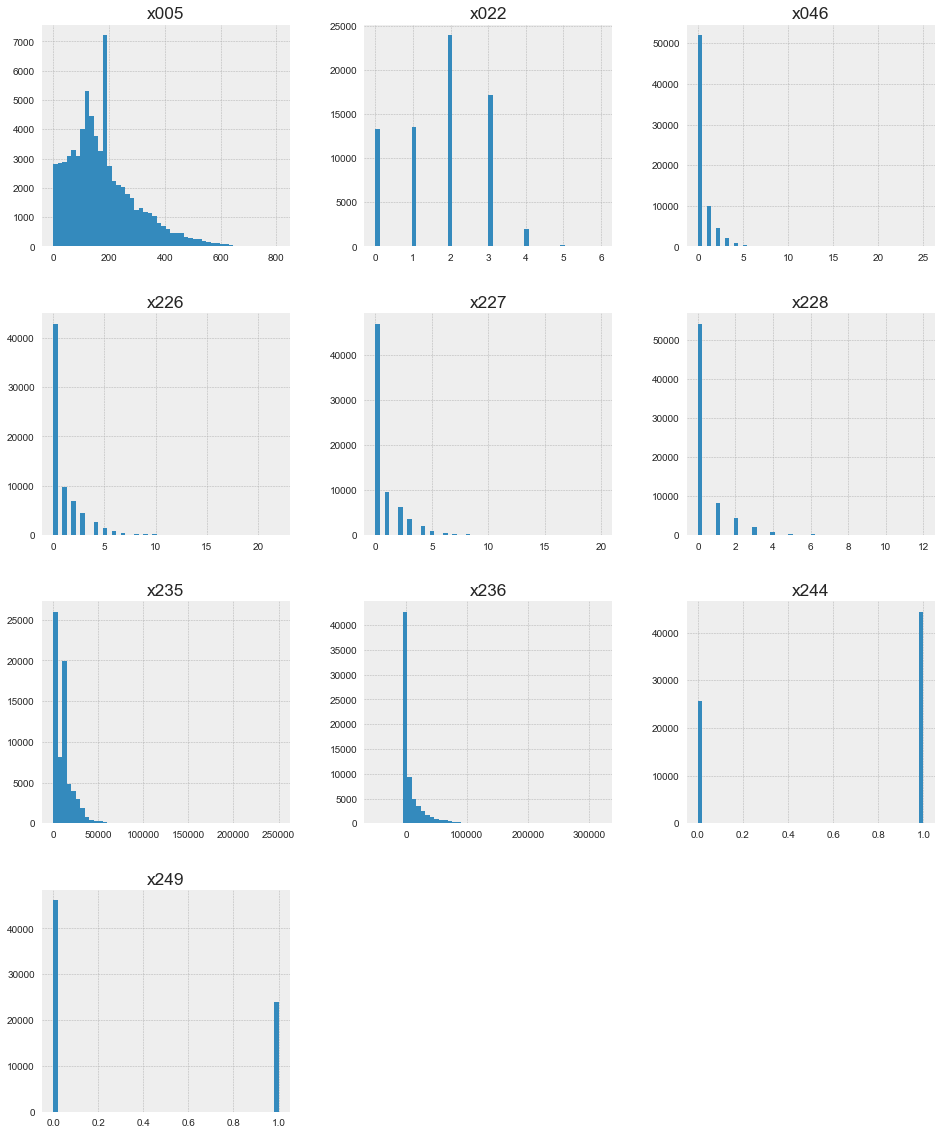

In [35]:
X.hist(figsize=(16, 20), bins=50, xlabelsize=10, ylabelsize=10); # ; avoid having the matplotlib verbose informations

### How y is distributed

count    70000.000000
mean       619.268771
std        118.522811
min        300.000000
25%        523.000000
50%        599.000000
75%        720.000000
max        839.000000
Name: y, dtype: float64


/Users/muralikorrapati/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


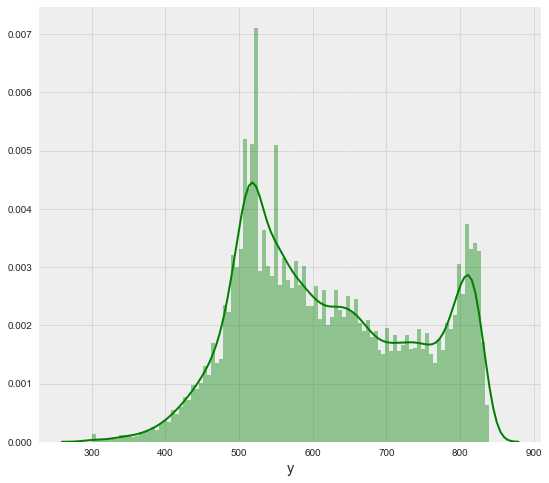

In [36]:
print(data_df['y'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(data_df['y'], color='g', bins=100, hist_kws={'alpha': 0.4});

### Check feature distributions

In [37]:
data_df.shape

(70000, 306)

In [32]:
X = data_df[filter_relevant_features.keys()].iloc[:10000,]
data = X.drop(['y'], axis=1)
target = data_df[['y']].iloc[:10000,]

In [33]:
list(filter_relevant_features.keys())

['x005',
 'x022',
 'x046',
 'x226',
 'x227',
 'x228',
 'x235',
 'x236',
 'x244',
 'x249',
 'y']

### Train/test split

In [34]:
from sklearn.model_selection import train_test_split

# train/test split (gives us test set)
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                  target, 
                                                  shuffle=True,
                                                  test_size=0.3, 
                                                  random_state=15)


In [35]:
import wallethub_estimator as wallet
import importlib
importlib.reload(wallet)

<module 'wallethub_estimator' from '/Users/muralikorrapati/WalletHub/Data Scientist Test/wallethub_estimator.py'>

### Define custom loss function

In [36]:
from sklearn.metrics.scorer import make_scorer

my_scorer = make_scorer(wallet.mean_square_error_range_func, greater_is_better=True)
my_loss = make_scorer(wallet.mean_square_error_range_func, greater_is_better=False)

### GridSearch model selector

In [121]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBRegressor
import statsmodels.api as sm

models1 = {
    'RandomForestRegressor': RandomForestRegressor(),
    #'ExtraTreesRegressor': ExtraTreesRegressor(),
    #'GradientBoostingRegressor': GradientBoostingRegressor(),
    #'SVR': SVR(),
    #'XGB': XGBRegressor(nthread=-1),
}

params1 = {
    'RandomForestRegressor': { 'n_estimators': [100], 'criterion': ['mae'], 'max_depth': [4] },
    #'ExtraTreesRegressor': { 'n_estimators': [10, 30, 100], 'criterion': ['mae'], 'max_depth': [4, 6] },
    #'GradientBoostingRegressor': { 'learning_rate': [i/10.0 for i in range(4,6)], 'criterion': ['mae'], 'max_depth': [2, 4, 6] },
    #'SVR': {'kernel': ['rbf'], "C": [1e1, 1e2, 1e3], "gamma": np.logspace(-2,-2)},
    #'SVR': {'kernel': ['poly'], "C": [1e0, 1e1], "gamma": [0.6, 0.7]},
    #'XGB': {'gamma':[i/10.0 for i in range(3,6)],'max_depth': [2,3,4]},
}

In [122]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

transformers={
    "scaler": StandardScaler(),
    "polynomial":PolynomialFeatures(5)
}

helper1 = wallet.WalletHubEstimator(models1, params1, transformers=transformers)
helper1.fit(X_train, y_train.values.ravel(), verbose=10) #, scoring=my_scorer
#helper1.get_score_summary(sort_by='max_score')

Applying transformers dict_keys(['scaler', 'polynomial'])
*****Running GridSearchCV for RandomForestRegressor*****
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__criterion=mae, estimator__max_depth=4, estimator__n_estimators=100 
[CV] estimator__criterion=mae, estimator__max_depth=4, estimator__n_estimators=100 
[CV] estimator__criterion=mae, estimator__max_depth=4, estimator__n_estimators=100 
[CV]  estimator__criterion=mae, estimator__max_depth=4, estimator__n_estimators=100, score=0.6632317642763024, total=536.8min
[CV]  estimator__criterion=mae, estimator__max_depth=4, estimator__n_estimators=100, score=0.6736016991725751, total=541.4min
[CV]  estimator__criterion=mae, estimator__max_depth=4, estimator__n_estimators=100, score=0.6509934583017178, total=545.1min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 545.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 545.1min finished


Best: 0.662609 using {'estimator__criterion': 'mae', 'estimator__max_depth': 4, 'estimator__n_estimators': 100}
Train: 0.693238 (0.005132) // Test : 0.662609 (0.009240) with: {'estimator__criterion': 'mae', 'estimator__max_depth': 4, 'estimator__n_estimators': 100}


In [123]:
helper1.get_score_summary(sort_by='mean_score')

RandomForestRegressor


,estimator,min_score,mean_score,max_score,std_score,estimator__criterion,estimator__max_depth,estimator__n_estimators
0,RandomForestRegressor,0.650993,0.662609,0.673602,0.00924028,mae,4,100


In [124]:
from sklearn.metrics import mean_squared_error, r2_score

model_name, model = helper1.best_model()

In [125]:
model_name, model.best_params_

('RandomForestRegressor',
 {'estimator__criterion': 'mae',
  'estimator__max_depth': 4,
  'estimator__n_estimators': 100})

In [126]:
helper1.refit_best_model(X_train, y_train.values.ravel())

In [38]:
y_pred = np.rint(helper1.predict(X_test))
y_test = y_test.values.ravel()
y_pred[:10]

array([ 668.,  522.,  769.,  704.,  522.,  522.,  586.,  658.,  804.,  787.])

In [39]:
y_test[:10]

array([613, 700, 746, 817, 539, 508, 634, 605, 835, 826])

RMSE:  3639.10181226
Accuracy:  0.69334447485


Text(0, 0.5, 'Predictions')

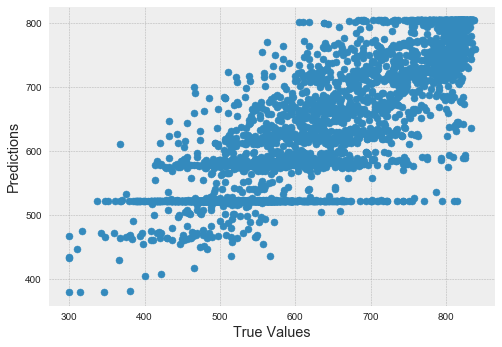

In [129]:
# model evaluation
rmse = np.sqrt(np.sum(np.square(y_pred-y_test)))
accuracy = r2_score(y_test, y_pred)

#printing values
#print("Slope: ", model.named_steps['gridsearchcv'].estimator.coef_)
#print("Intercept: ", model.intercept_)
print("RMSE: ", rmse)
#print("R2: ", r2)
print("Accuracy: ", accuracy)

plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

### Persist model to disk

In [130]:
from sklearn.externals import joblib
#file_whp = open('wallethub_predictor.pkl', 'w') 
#pickle.dump(helper1, file_whp, protocol=None, fix_imports=True)
joblib.dump(model.estimator, 'wallethub_predictor.pkl')

['wallethub_predictor.pkl']

In [37]:
from sklearn.externals import joblib
# Load the pickle file
helper1 = joblib.load('wallethub_predictor.pkl') 